# STEP.1 必要なライブラリのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import pydotplus
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from tensorflow.compat.v1.keras.models import load_model

# STEP.2 CSVファイルの読み込み

In [2]:
# CSVファイルの読み込み
df = pd.read_csv('ks-projects-201801.csv')
df.head(3)

# 使用するCPU数を指定しておく
cpu_cnt=-1

In [3]:
# 件数の確認
print(len(df))

378661


# STEP.3 欠損値の処理

In [4]:
# 欠損値の確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
# 暫定で０埋めにする
df['usd pledged'] = df['usd pledged'].fillna('0')
df.isnull().sum()

ID                  0
name                4
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

※↑usd pledgedは後で消すことになる  
本来であれば、平均値・中央値で埋める等検討する  
もし平均値をとる場合は、事前にデータの分布・分散を確認する（90点・95点・5点、の場合は平均値を使わない方が良い）  

# STEP.4 ダミー変数の作成

## STEP4-1.日付データの処理

仮説として、クラウドファンディングが発表された日と締め切りまでの日数差が影響を及ぼしているとして、説明変数に加える

In [6]:
# 日付型に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched']).dt.strftime('%Y-%m-%d'))

In [7]:
# launched と deadline の差をとって、日数を計算
df['datenum'] = (df['deadline']-df['launched']).astype('timedelta64[D]')

## STEP4-2.目的変数の処理

目的変数は、成功する場合のみをターゲットとするため、成功の場合は1、成功以外の場合は2とする

In [8]:
df.loc[df['state'] == 'successful', 'state_num'] = 1
df.loc[df['state'] != 'successful', 'state_num'] = 0

## STEP4-3.カテゴリ値の処理

カテゴリ値は事前にカテゴリ値毎に目的変数の件数を確認し、極端に偏っていないかなどを確認する

### categoryの確認

In [9]:
# カテゴリ値の種別を確認
vc = df['category'].value_counts()
print(vc)
print(type(vc))

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [10]:
# 件数上位10カテゴリの分布を確認しておおよその傾向をつかむ
df_wk = df.loc[:,['category', 'state_num']]
df_wk = df_wk[df_wk['category'].isin(['Product Design' , 'Documentary', 'Music', 'Tabletop Games', 'Shorts', 'Video Games', 'Food', 'Film & Video'])]
len(df_wk)

114148

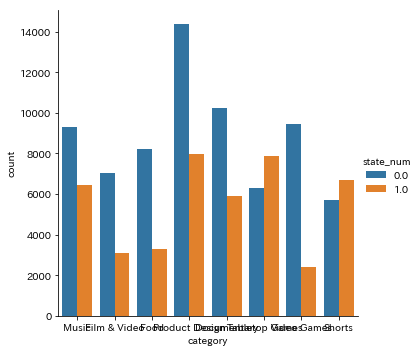

In [11]:
sns.catplot(x="category", hue="state_num", data=df_wk, kind="count")

↑ categoryは特定カテゴリ値での相関が強すぎる結果はないはずなので説明変数として有効

### main_categoryの確認

In [12]:
vc = df['main_category'].value_counts()
print(vc)

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64


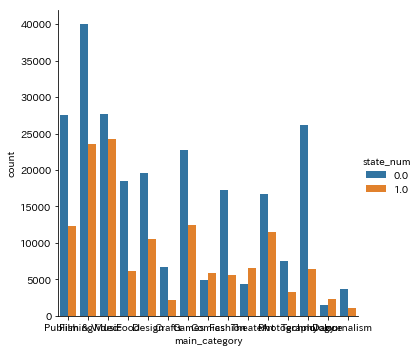

In [13]:
sns.catplot(x="main_category", hue="state_num", data=df, kind="count")

main_categoryは特定カテゴリ値での相関が強すぎる結果はないはずなので説明変数として有効

### currencyカテゴリの確認

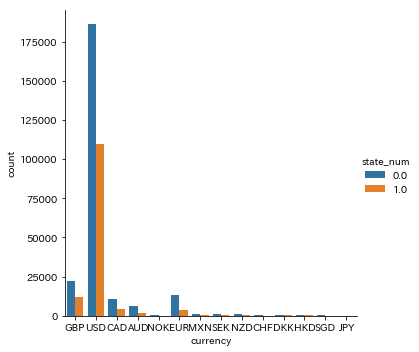

In [14]:
sns.catplot(x="currency", hue="state_num", data=df, kind="count")

currencyは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSDしかないのであれば説明変数で不要か

### countryカテゴリの確認

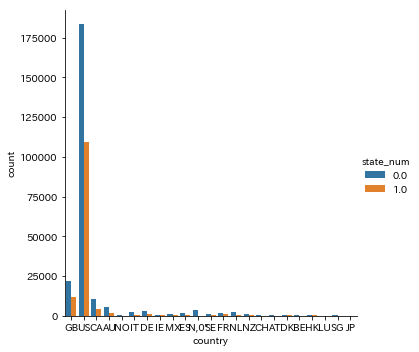

In [15]:
sns.catplot(x="country", hue="state_num", data=df, kind="count")

countryは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSAしかないのであれば説明変数で不要か

## STEP4-4.カテゴリ値の変換（OneHotEncoding）

In [16]:
# OneHotEncoding
#df = pd.get_dummies(df, columns=['category','main_category'])
#df.describe()

#### ※OneHotEncodinを実施したいが、学習に時間がかかりすぎるので今回はカテゴリ値に変換することで我慢する

## STEP4-4.カテゴリ値の変換（区分値）

In [17]:
# カテゴリ値版
# categoryをカテゴリ値に変換
labels, uniques = pd.factorize(df['category'])
df['category'] = labels

# main_categoryをカテゴリ値に変換
labels, uniques = pd.factorize(df['main_category'])
df['main_category'] = labels


## STEP4-5.一次前処理結果の確認

In [18]:
df.describe()

,ID,category,main_category,goal,pledged,backers,usd_pledged_real,usd_goal_real,datenum,state_num
count,3.786610e+05,378661.000000,378661.000000,3.786610e+05,3.786610e+05,378661.000000,3.786610e+05,3.786610e+05,378661.000000,378661.000000
mean,1.074731e+09,38.764401,4.964591,4.908079e+04,9.682979e+03,105.617476,9.058924e+03,4.545440e+04,34.481095,0.353762
std,6.190862e+08,34.478769,4.105380,1.183391e+06,9.563601e+04,907.185035,9.097334e+04,1.152950e+06,65.909173,0.478137
min,5.971000e+03,0.000000,0.000000,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,1.000000,0.000000
25%,5.382635e+08,9.000000,1.000000,2.000000e+03,3.000000e+01,2.000000,3.100000e+01,2.000000e+03,30.000000,0.000000
50%,1.075276e+09,30.000000,4.000000,5.200000e+03,6.200000e+02,12.000000,6.243300e+02,5.500000e+03,30.000000,0.000000
75%,1.610149e+09,55.000000,8.000000,1.600000e+04,4.076000e+03,56.000000,4.050000e+03,1.550000e+04,37.000000,1.000000
max,2.147476e+09,158.000000,14.000000,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,16739.000000,1.000000


# STEP.5 説明変数・目的変数の取り出し

## STEP5-1.不要説明変数の削除

以下説明変数は不要  
　- ID：恐らくlaunched毎に新しく振られるので意味がない  
　- currency：基礎解析結果、ほとんどUSDなので不要と判断  
　- country：基礎解析結果、ほとんどUSAなので不要と判断  
　- name：もし仮にネーミングが効くなら言語処理をしなければいけないので、今回はパス  
　- deadline：launchedとの日数差を説明変数にしたので不要  
　- launched：同↑  
　- state：目的変数として前処理したので不要  
　- backers：募集した結果集まった人数だと思われるので、予測時点では使えないので削除  
　- pledged：募集した結果集まった金額だと思われるので、予測時点では使えないので削除  
　- usd pledged：usd_pledged_realにより正確な値が入っていると思われるので削除  

In [19]:
# 不要な説明変数の設定
drop_col = ['ID', 'currency', 'country', 'name','deadline','launched','state','backers','pledged','usd pledged']

In [20]:
# 不要列の削除
df=df.drop(drop_col, axis=1)
df.head(3)

,category,main_category,goal,usd_pledged_real,usd_goal_real,datenum,state_num
0,0,0,1000.0,0.0,1533.95,59.0,0.0
1,1,1,30000.0,2421.0,30000.00,60.0,0.0
2,1,1,45000.0,220.0,45000.00,45.0,0.0


## STEP5-2.説明変数間の相関を確認

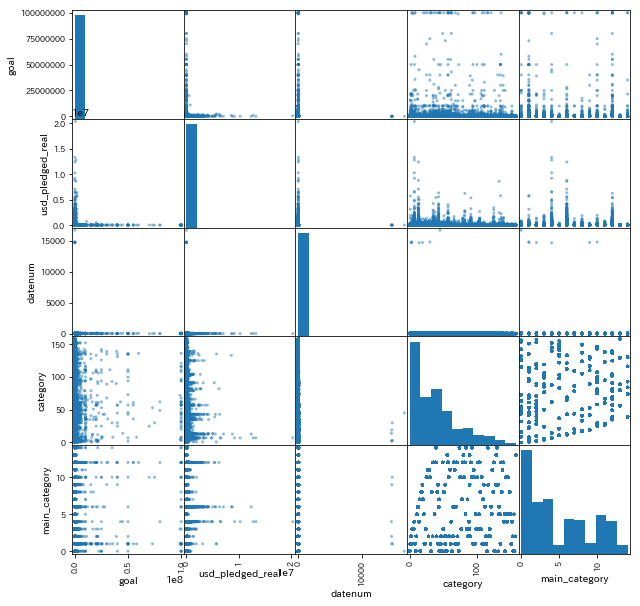

In [21]:
df_wk = df.loc[:,['goal', 'usd_pledged_real', 'datenum', 'category', 'main_category']]
pd.plotting.scatter_matrix(df_wk, figsize=(10,10))
plt.show()

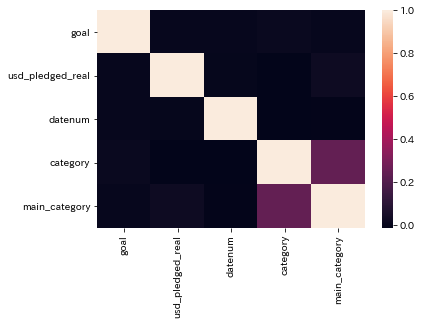

In [22]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_wk.corr())
plt.show()

# メモリ食うので削除
del df_wk

恐らく相関が強すぎる説明変数はなくなったのでOK  
いったん使用する説明変数はここで確定させる

# STEP.6 外れ値処理

## STEP6-1.箱ひげ図でデータの分布を確認する

goal          AxesSubplot(0.125,0.125;0.352273x0.755)
datenum    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

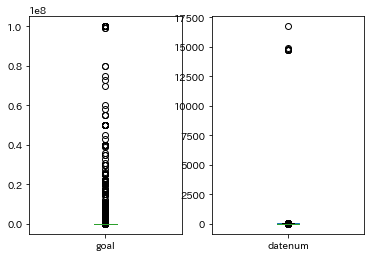

In [23]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

明らかに外れ値があることが見て取れるので削除しにかかる  
念のため、統計量も確認しておく

In [24]:
# 統計量を再確認する
df_wk.describe()

,goal,datenum
count,3.786610e+05,378661.000000
mean,4.908079e+04,34.481095
std,1.183391e+06,65.909173
min,1.000000e-02,1.000000
25%,2.000000e+03,30.000000
50%,5.200000e+03,30.000000
75%,1.600000e+04,37.000000
max,1.000000e+08,16739.000000


## STEP6-2.外れ値の削除処理

3σより外の値は外れ値とみなして削除する

In [25]:
# 3σで削除する関数定義
def sigma3(df, col):
    mean = df[col].mean()
    sigma = df[col].std()
    low = mean - 3 * sigma
    high = mean + 3 * sigma
    df = df[(df[col]>low) & (df[col]<high)]
    sns.distplot(df[col])
    return df

### datenum

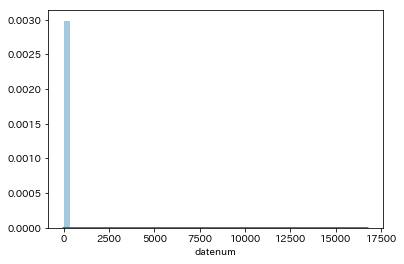

In [26]:
col = 'datenum'
# 現状の散布図確認
sns.distplot(df[col])

In [27]:
df[col].describe()

count    378661.000000
mean         34.481095
std          65.909173
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max       16739.000000
Name: datenum, dtype: float64

↑MAX値が16739日のデータがあるので明らか外れ値

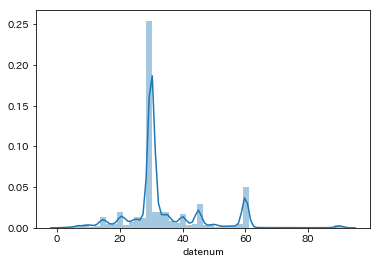

In [28]:
# 3σより外の値を消す
df = sigma3(df, col)

In [29]:
df[col].describe()

count    378654.000000
mean         34.203394
std          12.793171
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: datenum, dtype: float64

おさまったっぽいのでいったんこれでヨシとする

### goal

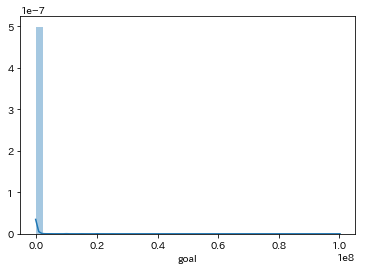

In [30]:
col = 'goal'

# 現状の散布図確認
sns.distplot(df[col])

In [31]:
df[col].describe().apply(lambda x: format(x, 'f'))

count       378654.000000
mean         49081.600876
std        1183402.182306
min              0.010000
25%           2000.000000
50%           5200.000000
75%          16000.000000
max      100000000.000000
Name: goal, dtype: object

↑MAX値が100000000.000000のデータがあるので明らか外れ値

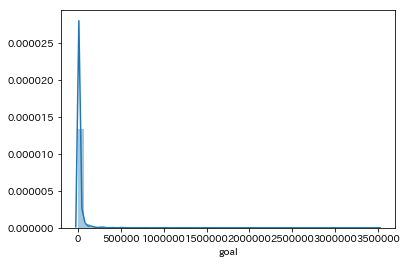

In [32]:
# 3σより外の値を消す
df = sigma3(df, col)

In [33]:
df[col].describe().apply(lambda x: format(x, 'f'))

count     378249.000000
mean       25619.495415
std       111742.421127
min            0.010000
25%         2000.000000
50%         5100.000000
75%        16000.000000
max      3500000.000000
Name: goal, dtype: object

まだ外れ値っぽいのでもう一回やる

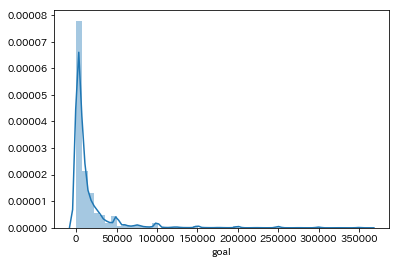

In [34]:
df = sigma3(df, col)

In [35]:
df[col].describe().apply(lambda x: format(x, 'f'))

count    374678.000000
mean      17231.733562
std       35237.054407
min           0.010000
25%        2000.000000
50%        5000.000000
75%       15000.000000
max      360360.000000
Name: goal, dtype: object

おさまったっぽいのでいったんこれでヨシとする

## STEP6-3.再度、箱ひげ図でデータの分布を確認する

goal          AxesSubplot(0.125,0.125;0.352273x0.755)
datenum    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

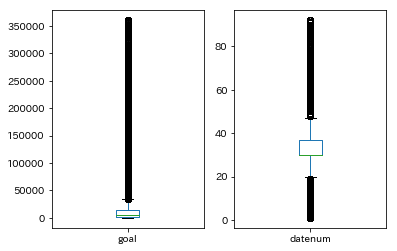

In [36]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

まぁそれなりっぽくなったので、これでOK？

## STEP6-4.データ件数がどの程度減ったか確認する

In [37]:
len(df)

374678

件数 378661→374678  
3,983件減少しているが、370,000件あれば学習には使えると思うので、これでヨシ

## STEP6-5.説明変数と目的変数のデータを用意する

In [38]:
y = df['state_num'].values
X = df[df.columns[df.columns != 'state_num']]

In [39]:
df.describe()

,category,main_category,goal,usd_pledged_real,usd_goal_real,datenum,state_num
count,374678.000000,374678.000000,374678.000000,3.746780e+05,374678.000000,374678.000000,374678.000000
mean,38.694823,4.954985,17231.733562,8.574230e+03,16688.087877,34.134118,0.357168
std,34.437139,4.099854,35237.054407,7.390574e+04,34432.991052,12.756912,0.479166
min,0.000000,0.000000,0.010000,0.000000e+00,0.010000,1.000000,0.000000
25%,9.000000,1.000000,2000.000000,3.286000e+01,2000.000000,30.000000,0.000000
50%,30.000000,4.000000,5000.000000,6.360000e+02,5139.010000,30.000000,0.000000
75%,55.000000,8.000000,15000.000000,4.069860e+03,15000.000000,37.000000,1.000000
max,158.000000,14.000000,360360.000000,1.328523e+07,570794.870000,92.000000,1.000000


# STEP.7 機械的説明変数選択

## STEP7-1.ステップワイズ法

In [40]:
estimator = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, n_jobs=cpu_cnt)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='accuracy')

rfecv.fit(X, y)

RFECV(cv=10,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=10000, n_iter_no_change=5, n_jobs=-1,
                              penalty='none', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [41]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1]


全部重要！

## STEP7-2.埋め込み法

In [42]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10, n_jobs=cpu_cnt)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=-1, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [43]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True, False, False, False,  True])

In [44]:
df.describe()

,category,main_category,goal,usd_pledged_real,usd_goal_real,datenum,state_num
count,374678.000000,374678.000000,374678.000000,3.746780e+05,374678.000000,374678.000000,374678.000000
mean,38.694823,4.954985,17231.733562,8.574230e+03,16688.087877,34.134118,0.357168
std,34.437139,4.099854,35237.054407,7.390574e+04,34432.991052,12.756912,0.479166
min,0.000000,0.000000,0.010000,0.000000e+00,0.010000,1.000000,0.000000
25%,9.000000,1.000000,2000.000000,3.286000e+01,2000.000000,30.000000,0.000000
50%,30.000000,4.000000,5000.000000,6.360000e+02,5139.010000,30.000000,0.000000
75%,55.000000,8.000000,15000.000000,4.069860e+03,15000.000000,37.000000,1.000000
max,158.000000,14.000000,360360.000000,1.328523e+07,570794.870000,92.000000,1.000000


In [45]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
X.columns[removed_idx]

Index(['goal', 'usd_pledged_real', 'usd_goal_real'], dtype='object')

埋め込み法をやってみたものの、さすがにこの３つを消すと全く予測できなくなりそうなので、いったん残す  
後で余裕があれば、消してやってみる  

# STEP.8 学習用データ準備

## STEP8-1.ホールドアウト

In [46]:
# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936


## STEP8-2. 説明変数の標準化

In [47]:
stdsc = StandardScaler()

X_train_kf = stdsc.fit_transform(X_train)
X_test_kf = stdsc.fit_transform(X_test)

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))
print('X_train_kf:',len(X_train_kf))
print('X_test_kf:',len(X_test_kf))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936
X_train_kf: 299742
X_test_kf: 74936


# STEP.9 学習

## 9-1.ロジスティック回帰で交差検定を実施してみる(cross_val_score)

In [48]:
# モデル作成
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, n_jobs=cpu_cnt)


# 交差検定
scores_accuracy = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='accuracy', n_jobs=cpu_cnt)
scores_recall = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='recall', n_jobs=cpu_cnt)
scores_precision = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='precision', n_jobs=cpu_cnt)
scores_neg_log_lossl = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='neg_log_loss', n_jobs=cpu_cnt)
scores_auc = cross_val_score(clf, X_train_kf, y_train, cv=5, scoring='roc_auc', n_jobs=cpu_cnt)


In [49]:
# 各分割におけるスコア
print('Cross-Validation scores(accuracy): {}'.format(scores_accuracy))
print('Cross-Validation scores(recall): {}'.format(scores_recall))
print('Cross-Validation scores(precision): {}'.format(scores_precision))
print('Cross-Validation scores(log_loss): {}'.format(scores_neg_log_lossl))
print('Cross-Validation scores(AUC): {}'.format(scores_auc))
print('')
print('Average score(accuracy): {}'.format(np.mean(scores_accuracy)))
print('Average score(recall): {}'.format(np.mean(scores_recall)))
print('Average score(precision): {}'.format(np.mean(scores_precision)))
print('Average score(log_loss): {}'.format(np.mean(scores_neg_log_lossl)))
print('Average score(AUC): {}'.format(np.mean(scores_auc)))

Cross-Validation scores(accuracy): [0.97411133 0.97271014 0.96990775 0.97389404 0.97521144]
Cross-Validation scores(recall): [0.99967329 0.99962662 0.99967329 1.         1.        ]
Cross-Validation scores(precision): [0.93272078 0.92935867 0.92259649 0.93192692 0.93514033]
Cross-Validation scores(log_loss): [-0.1710889  -0.16324015 -0.17643991 -0.17745419 -0.17701804]
Cross-Validation scores(AUC): [0.99307248 0.99374433 0.99272287 0.99376586 0.9932409 ]

Average score(accuracy): 0.9731669396217286
Average score(recall): 0.9997946420237096
Average score(precision): 0.9303486379697201
Average score(log_loss): -0.17304823903517502
Average score(AUC): 0.9933092887494219


正答率が高すぎる気がする。  
loglossもAUCも値が良すぎる。
何故？

## 9-2.ロジスティック回帰で交差検定を実施してみる(cross_validate)

In [50]:
scoring = {"accuracy": "accuracy"
           , "recall": "recall"
           , "precision":"precision"
           , "log_loss":"neg_log_loss"
           , "AUC":"roc_auc"}

scores = cross_validate(clf, X_train_kf, y_train, cv=5, scoring=scoring, n_jobs=cpu_cnt)

In [51]:
print('Cross-Validation scores(accuracy): {}'.format(scores['test_accuracy']))
print('Cross-Validation scores(recall): {}'.format(scores['test_recall']))
print('Cross-Validation scores(precision): {}'.format(scores['test_precision']))
print('Cross-Validation scores(log_loss): {}'.format(scores['test_log_loss']))
print('Cross-Validation scores(AUC): {}'.format(scores['test_AUC']))
print('')
print('Average score(accuracy): {}'.format(np.mean(scores['test_accuracy'])))
print('Average score(recall): {}'.format(np.mean(scores['test_recall'])))
print('Average score(precision): {}'.format(np.mean(scores['test_precision'])))
print('Average score(log_loss): {}'.format(np.mean(scores['test_log_loss'])))
print('Average score(AUC): {}'.format(np.mean(scores['test_AUC'])))

Cross-Validation scores(accuracy): [0.97411133 0.97271014 0.96990775 0.97389404 0.97521144]
Cross-Validation scores(recall): [0.99967329 0.99962662 0.99967329 1.         1.        ]
Cross-Validation scores(precision): [0.93272078 0.92935867 0.92259649 0.93192692 0.93514033]
Cross-Validation scores(log_loss): [-0.1710889  -0.16324015 -0.17643991 -0.17745419 -0.17701804]
Cross-Validation scores(AUC): [0.99307248 0.99374433 0.99272287 0.99376586 0.9932409 ]

Average score(accuracy): 0.9731669396217286
Average score(recall): 0.9997946420237096
Average score(precision): 0.9303486379697201
Average score(log_loss): -0.17304823903517502
Average score(AUC): 0.9933092887494219


## 9-3.ROC曲線を描いてみる

In [52]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

In [53]:
# 一応、モデルのスコアも再度表示
score_acs = accuracy_score(y_test, y_pred_test)
score_logloss = log_loss(y_test, y_pred_test)
score_auc = roc_auc_score(y_test, y_pred_test)

print('acs:', score_acs)
print('log_loss:-', score_logloss)
print('AUC:', score_auc)

acs: 0.9598457350272233
log_loss:- 1.3869112864438158
AUC: 0.9688128355548185


In [54]:
# ROC曲線の情報を取得
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

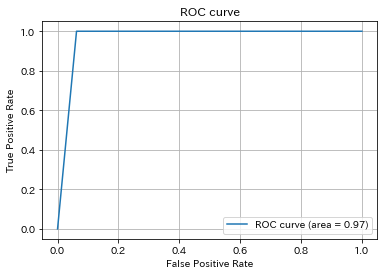

In [55]:
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%score_auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

急激にカーブ上がりすぎ。

## 9-4.説明変数の重みチェック

In [56]:
# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))


w0 = -9.760, w1 = 0.016, w2 = -0.069, w3 = -0.071, w4 = 115.168, w5 = -48.472, w6 = -0.076


In [57]:
X_train.describe()

,category,main_category,goal,usd_pledged_real,usd_goal_real,datenum
count,299742.000000,299742.000000,299742.000000,2.997420e+05,299742.000000,299742.000000
mean,38.681152,4.952813,17214.851470,8.613138e+03,16666.891890,34.119863
std,34.451386,4.099020,35191.778283,7.396589e+04,34352.102421,12.747811
min,0.000000,0.000000,0.010000,0.000000e+00,0.010000,1.000000
25%,9.000000,1.000000,2000.000000,3.365000e+01,2000.000000,30.000000
50%,30.000000,4.000000,5000.000000,6.366800e+02,5200.000000,30.000000
75%,55.000000,8.000000,15000.000000,4.085000e+03,15000.000000,37.000000
max,158.000000,14.000000,360360.000000,1.239314e+07,570794.870000,92.000000


usd_pledged_realは出資金の意味だったので、そりゃ重くなる。
なので削除してもう一回。

# STEP.10 説明変数を一つ減らして出直し

## 10.1 再度学習用データの準備

In [58]:
# 不要列の削除
df=df.drop(['usd_pledged_real'], axis=1)
y = df['state_num'].values
X = df[df.columns[df.columns != 'state_num']]
df.head(3)

,category,main_category,goal,usd_goal_real,datenum,state_num
0,0,0,1000.0,1533.95,59.0,0.0
1,1,1,30000.0,30000.00,60.0,0.0
2,1,1,45000.0,45000.00,45.0,0.0


In [59]:
# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936


In [60]:
stdsc = StandardScaler()

X_train_kf = stdsc.fit_transform(X_train)
X_test_kf = stdsc.fit_transform(X_test)

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))
print('X_train_kf:',len(X_train_kf))
print('X_test_kf:',len(X_test_kf))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936
X_train_kf: 299742
X_test_kf: 74936


## 10.2 検定を関数化しておく

In [61]:
# 交差検定
def fx_cross_validate(estimator,X, y):
    scoring = {"accuracy": "accuracy"
               , "recall": "recall"
               , "precision":"precision"
               , "log_loss":"neg_log_loss"
               , "AUC":"roc_auc"}
    
    scores = cross_validate(estimator, X, y, cv=5, scoring=scoring)
    
    print('Cross-Validation scores(accuracy): {}'.format(scores['test_accuracy']))
    print('Cross-Validation scores(recall): {}'.format(scores['test_recall']))
    print('Cross-Validation scores(precision): {}'.format(scores['test_precision']))
    print('Cross-Validation scores(log_loss): {}'.format(scores['test_log_loss']))
    print('Cross-Validation scores(AUC): {}'.format(scores['test_AUC']))
    print('')
    print('Average score(accuracy): {}'.format(np.mean(scores['test_accuracy'])))
    print('Average score(recall): {}'.format(np.mean(scores['test_recall'])))
    print('Average score(precision): {}'.format(np.mean(scores['test_precision'])))
    print('Average score(log_loss): {}'.format(np.mean(scores['test_log_loss'])))
    print('Average score(AUC): {}'.format(np.mean(scores['test_AUC'])))

In [62]:
# ROC曲線
def fx_roc_curve(y,y_predict):
    
    # 一応、モデルのスコアも再度表示
    score_acs = accuracy_score(y_test, y_pred_test)
    score_logloss = log_loss(y_test, y_pred_test)
    score_auc = roc_auc_score(y_test, y_pred_test)
    
    print('acs:', score_acs)
    print('log_loss:-', score_logloss)
    print('AUC:', score_auc)
    
    # ROC曲線の情報を取得
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%score_auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

In [63]:
def fx_confusion_matrix(y,y_predict):    
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_predict), 
                        index=['Actual = Nagative', 'Actual = Positive'], 
                        columns=['predict = Nagative', 'predict = Positive'])
    
    print(conf_mat)

## 10-3.交差検定/ROC曲線

In [64]:
# モデル作成
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, n_jobs=cpu_cnt)
fx_cross_validate(clf, X_train_kf, y_train)

Cross-Validation scores(accuracy): [0.64646616 0.64519842 0.64423093 0.64427504 0.64333495]
Cross-Validation scores(recall): [0.08709045 0.09427798 0.03005694 0.04135356 0.01008168]
Cross-Validation scores(precision): [0.53314286 0.52008239 0.54117647 0.52990431 0.55670103]
Cross-Validation scores(log_loss): [-0.62654083 -0.6269627  -0.62751018 -0.62568341 -0.62686497]
Cross-Validation scores(AUC): [0.63500493 0.6290753  0.6295639  0.62886089 0.63562083]

Average score(accuracy): 0.6447010990839883
Average score(recall): 0.05257212205021196
Average score(precision): 0.5362014108336831
Average score(log_loss): -0.6267124194849764
Average score(AUC): 0.6316251692517217


In [65]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.6468052738336714
log_loss:- 12.198924992219688
AUC: 0.5131462280759541


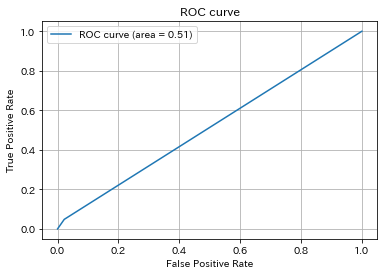

In [66]:
fx_roc_curve(y_test, y_pred_test)

In [67]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               47180                1061
Actual = Positive               25406                1289


今度は精度が落ちすぎ。  
だが、「usd_pledged_real」がリーケージを起こしていたことは証明できた。  
#### できればカテゴリ値をOneHotに置き換えて実行したいが、計算コストがかかりすぎるのでいったんこのまま進める

# STEP.11 SVMの実装

## 11-1.SVMの実装(時間かかりすぎで動かず)

In [68]:
#clf = SVC(C=5, kernel='rbf', gamma=1)
# 交差検定は時間かかるのでいったんパス
#fx_cross_validate(clf, X_train_kf, y_train)

In [69]:
# いったんモデルを作ってみる
#clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
#y_pred_test = clf.predict(X_test_kf)

In [70]:
#fx_roc_curve(y_test, y_pred_test)

In [71]:
#fx_confusion_matrix(y_test, y_pred_test)

## 11-2.LinearSVCの実装

In [72]:
tuned_parameters = [{'C': np.logspace(-1, 0.5, 1,2)}]

In [73]:
model = LinearSVC(loss='hinge', class_weight='balanced', random_state=0)

clf = GridSearchCV(model, tuned_parameters, cv=5, scoring='precision')
# 交差検定は時間かかるのでいったんパス
#fx_cross_validate(clf, X_train_kf, y_train)

In [74]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the num

acs: 0.5130778264118715
log_loss:- 16.81804429326409
AUC: 0.5895749403517525


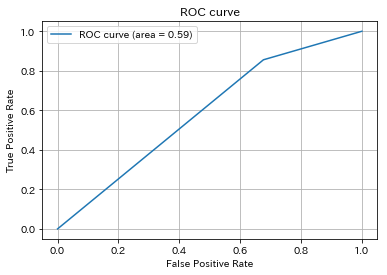

In [75]:
fx_roc_curve(y_test, y_pred_test)

In [76]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               15607               32634
Actual = Positive                3854               22841


# STEP.12 決定木の実装

In [77]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
fx_cross_validate(clf, X_train_kf, y_train)

Cross-Validation scores(accuracy): [0.65352216 0.65450633 0.65167059 0.65283245 0.65209268]
Cross-Validation scores(recall): [0.41108933 0.40721553 0.4077756  0.40704784 0.404014  ]
Cross-Validation scores(precision): [0.519309   0.52133126 0.51606615 0.51821261 0.51699218]
Cross-Validation scores(log_loss): [-3.67941273 -3.64074441 -3.67328387 -3.67533899 -3.65003651]
Cross-Validation scores(AUC): [0.65012555 0.64807903 0.6463665  0.64792571 0.646844  ]

Average score(accuracy): 0.6529248428424779
Average score(recall): 0.40742846132589977
Average score(precision): 0.5183822409466516
Average score(log_loss): -3.663763301851977
Average score(AUC): 0.6478681574843891


In [78]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.6466851713462154
log_loss:- 12.203174618043398
AUC: 0.5924998308832116


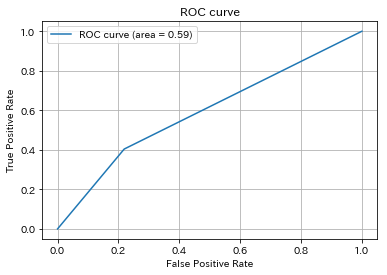

In [79]:
fx_roc_curve(y_test, y_pred_test)

In [80]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               37674               10567
Actual = Positive               15909               10786


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0143007 to fit



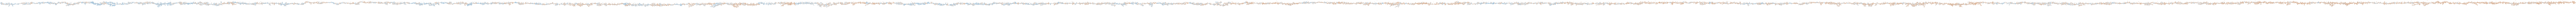

In [81]:
# 決定木の描画
#dot_data = StringIO() #dotファイル情報の格納先

# メモリ不足で断念

dot_data = export_graphviz(clf, out_file=None,  
                     feature_names=["category","main_category","goal","usd_goal_real","datenum"],  
                     class_names=["0","1","2","3","4"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())


# STEP.13 ランダムフォレストの実装

In [82]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234, n_jobs=cpu_cnt)
fx_cross_validate(clf, X_train_kf, y_train)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross-Validation scores(accuracy): [0.64259621 0.64259621 0.64259621 0.64260693 0.64260096]
Cross-Validation scores(recall): [0. 0. 0. 0. 0.]
Cross-Validation scores(precision): [0. 0. 0. 0. 0.]
Cross-Validation scores(log_loss): [-0.62323246 -0.62346098 -0.62445842 -0.6240808  -0.62471988]
Cross-Validation scores(AUC): [0.64522893 0.64178861 0.64115578 0.64196342 0.63933373]

Average score(accuracy): 0.6425993021029688
Average score(recall): 0.0
Average score(precision): 0.0
Average score(log_loss): -0.6239905085283726
Average score(AUC): 0.6418940920210584


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.643762677484787
log_loss:- 12.30400122587462
AUC: 0.5


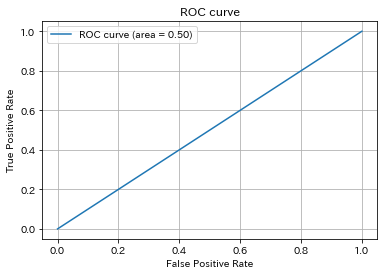

In [84]:
fx_roc_curve(y_test, y_pred_test)

In [85]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               48241                   0
Actual = Positive               26695                   0


[0.00614003 0.01928517 0.59750613 0.27234331 0.10472536]


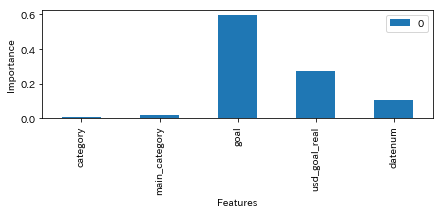

In [86]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

# STEP.14 XGBoostでの実装

In [87]:
dtrain = xgb.DMatrix(X_train_kf, label=y_train)
dtest = xgb.DMatrix(X_test_kf, label=y_test)

In [88]:
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1, n_jobs=cpu_cnt)
clf_cv.fit(X_train_kf, y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.5min finished


{'max_depth': 6, 'n_estimators': 200} 0.6985274002308652


In [89]:
# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_, n_jobs=cpu_cnt)
clf.fit(X_train_kf, y_train)
# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.7007980143055407
log_loss:- 10.334134919386857
AUC: 0.6305715276966825


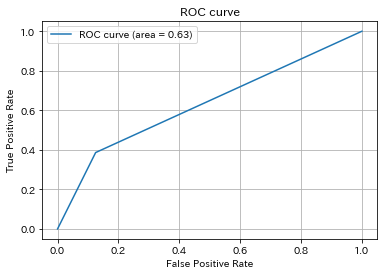

In [90]:
fx_roc_curve(y_test, y_pred_test)

# STEP.15 ニューラルネットワークで実装

In [91]:
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=5))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

W0808 07:27:55.738386 140504262239936 deprecation.py:506] From /home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 299742 samples, validate on 74936 samples
Epoch 1/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6254 - acc: 0.6458 - val_loss: 960.0137 - val_acc: 0.6383
Epoch 2/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6194 - acc: 0.6501 - val_loss: 891.1571 - val_acc: 0.6438
Epoch 3/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6180 - acc: 0.6519 - val_loss: 709.9813 - val_acc: 0.6438
Epoch 4/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6173 - acc: 0.6524 - val_loss: 706.0503 - val_acc: 0.6438
Epoch 5/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6166 - acc: 0.6542 - val_loss: 1195.4570 - val_acc: 0.6438
Epoch 6/50
299742/299742 [==============================] - 17s 56us/sample - loss: 0.6161 - acc: 0.6556 - val_loss: 1083.3051 - val_acc: 0.6438
Epoch 7/50
299742/299742 [==============================] - 17s 56us/sample - loss:

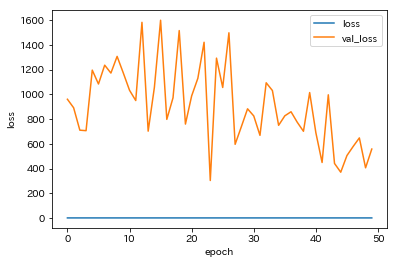

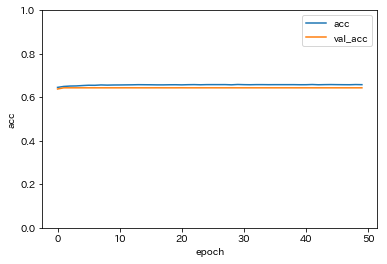

In [92]:
# 計算の実行
fit = model.fit(X_train_kf, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [93]:
y_pred_test = np.argmax(model.predict(X_test_kf),axis=1)

acs: 0.6607505070993914
log_loss:- 11.717307886656068
AUC: 0.5595221530451977


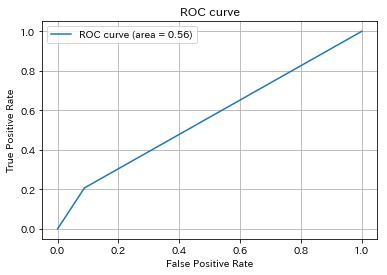

In [94]:
fx_roc_curve(y_test, y_pred_test)